In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nibabel as nib

import pickle

import preprocessing
import utils
import nets_LV

from utils import img_extended

from sklearn import metrics
from skimage.transform import resize

import matplotlib.pyplot as plt

In [22]:
%matplotlib inline

In [23]:
plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'medium'

plt.rcParams['lines.linewidth'] = 1

## Dataset

In [13]:
train_dir = '/home/sergio/Documents/04. Thesis/mood_sn/data/train_brain'
holdout_dir = '/home/sergio/Documents/04. Thesis/mood_sn/data/holdout_brain'

train_dset = preprocessing.brain_dataset(data_dir=train_dir, sample_number = 8, train = True)
train_loader = DataLoader(train_dset, batch_size=8,shuffle=True,num_workers=8,
                         collate_fn = preprocessing.collate_fn)

holdout_dset = preprocessing.brain_dataset(data_dir=holdout_dir, sample_number = 8, train = False)
holdout_loader = DataLoader(holdout_dset, batch_size=8,shuffle=True,num_workers=8,
                         collate_fn = preprocessing.collate_fn)


Retrieve a sample (8 slices from 8 volumes)

In [14]:
X_hl = next(iter(holdout_loader))

Images are in the attribute img of the img_extended object. Coordinates are in coord (used to condition both VQ-VAE and AR)

In [15]:
print(X_hl.img.shape)
print(X_hl.coord.shape)

(64, 160, 160)
(64, 1)


(-0.5, 159.5, 159.5, -0.5)

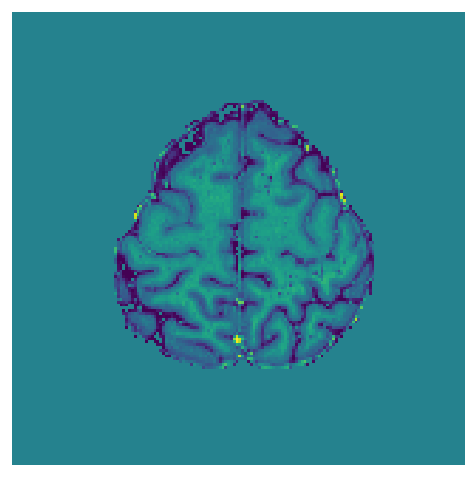

In [18]:
plt.imshow(X_hl.img[42])
plt.axis('off')

# Model training
## VQ-VAE

Training of VQ-VAE network. 

In [8]:
device = torch.device('cuda')

In [9]:
model = nets_LV.VQVAE(1,n_channels=(16,32,64,256),code_size=128,n_res_block=2,cond_channels=1,dropout_p=.1)

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
tracker = utils.train_tracker()

In [ ]:
utils.train_epochs(model, optimizer, tracker, train_loader, holdout_loader, epochs=600, device = device,)

In [ ]:
tracker.plot(300)

Utility below allows to save / load checkpoints of the training. Note that when training Prior AR below, VQ-VAE model parameters will be loaded from a checkpint

In [ ]:
utils.save_checkpoint(model,optimizer,tracker,'./checkpoints/brain_vqvae.pt')

In [13]:
chpt = torch.load('./checkpoints/brain_vqvae.pt')
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])
tracker = chpt['tracker']

## Prior AR
Definition and training of prior model. feat_ext_mdl is the vq-vae network that must have been trained in section above, its weights are loaded from checkpoint

In [ ]:
feat_ext_mdl = nets_LV.VQVAE(1,n_channels=(16,32,64,256),code_size=128,n_res_block=2,cond_channels=1, dropout_p=.1)

feat_ext_mdl.to(device)
chpt = torch.load('./checkpoints/brain_vqvae.pt')
feat_ext_mdl.load_state_dict(chpt['model'])

model = nets_LV.VQLatentSNAIL(feature_extractor_model=feat_ext_mdl,
                              shape=(20,20), n_block = 4, n_res_block = 4, n_channels = 128, cond_channels=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
tracker = utils.train_tracker()

In [ ]:
utils.train_epochs(model, optimizer, tracker, train_loader, holdout_loader, epochs=600, device = device,)

In [ ]:
tracker.plot(300)

In [ ]:
utils.save_checkpoint(model,optimizer,tracker,'./checkpoints/brain_prior.pt')

In [ ]:
chpt = torch.load('./checkpoints/brain_prior.pt')
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])
tracker = chpt['tracker']

# Anomaly detection
## Loading of toy examples

Only 32 slices for each volume are processed:

In [24]:
def load_volume_brain(source_file, slices = 32):
        nimg = nib.load(source_file)
        nimg_array = nimg.get_fdata()
        vol_s = nimg_array.shape

        nimg_array = resize(nimg_array, (160, 160, slices))
        nimg_array = nimg_array.transpose((2,1,0))
        nimg_array = nimg_array[:, ::-1, :]
        
        # Normalize non-zeros
        nimg_array[nimg_array<0.05] = 0

        non_zero_mask = np.where(nimg_array>0.05)
        mu,sigma = nimg_array[non_zero_mask].mean(),nimg_array[non_zero_mask].std()
        nimg_array[non_zero_mask] = (nimg_array[non_zero_mask] - mu) / (sigma+1e-5)
        
        coord = np.linspace(-.5,.5,slices)[:, np.newaxis]
        
        img_batch = img_extended(nimg_array,
                                   np.zeros(slices,dtype='uint8'),
                                   np.zeros(slices,dtype='uint8'),
                                   np.zeros(slices,dtype='uint8'),
                                   coord,
                                   np.zeros(slices,dtype='uint8'),
                                  )
        
        return img_batch, vol_s, nimg.affine

def load_seg_brain(source_file, slices = 32):
        nimg = nib.load(source_file)
        nimg_array = nimg.get_fdata()
        vol_s = nimg_array.shape

        nimg_array = resize(nimg_array, (160, 160, slices))
        nimg_array = nimg_array.transpose((2,1,0))
        nimg_array = nimg_array[:, ::-1, :]
        nimg_array = (nimg_array > .5)
        return nimg_array
    
toy_dir = '/home/sergio/Documents/bigdrive/data/mood/data_toy/brain/toy'
toy_seg_dir = '/home/sergio/Documents/bigdrive/data/mood/data_toy/brain/toy_label/pixel'

mood_test = []
mood_test_seg = []

for i in range(4):
    mood_test.append(load_volume_brain(os.path.join(toy_dir,'toy_{}.nii.gz'.format(i)))[0])
    mood_test_seg.append(load_seg_brain(os.path.join(toy_seg_dir,'toy_{}.nii.gz'.format(i))))

In [30]:
# Shape of image / segmentation (32,160,160)
print(mood_test[0].img.shape)
print(mood_test_seg[0].shape)

(32, 160, 160)
(32, 160, 160)


## Sample-wise score


Sample-wise score is derived from the density of the latent variables as estimated by the AR prior model. Specifically, we hypothesize that the prior model will assign low probability to the latent variables encoding image areas where anomalies exist. 

We use as score the estimated cross-entropy for the latent variables, considering only the values for the latent variables with cross-entropy above a threshold λ. The 98 percentile of the cross-entropy values observed in the holdout dataset has been used as threshold, in both datasets this corresponded broadly to the value 7. 

$$Score_{sample} = \sum_{i=1}^N \xi(p(x))$$

$$
\xi(z) = \begin{cases}
     -\log(z) \text{ if} -\log(z) > \lambda \\
     0 \text{ otherwise} \\
    \end{cases}
$$

In [33]:
pred = []

model.eval()
for X in mood_test:
    x_img = torch.from_numpy(X.img.copy()).to(device).float()
    x_coord = torch.from_numpy(X.coord).to(device).float()

    with torch.no_grad():
        codes = model.retrieve_codes(x_img,x_coord).flatten(1)
        loss = model.loss(x_img,cond = x_coord, reduction='none')['loss'].flatten(1)
        
        score = torch.sum(loss*(loss>7),1).float()
        pred.append([score.cpu().numpy()])

pred = np.concatenate(pred,1).reshape(4,32)

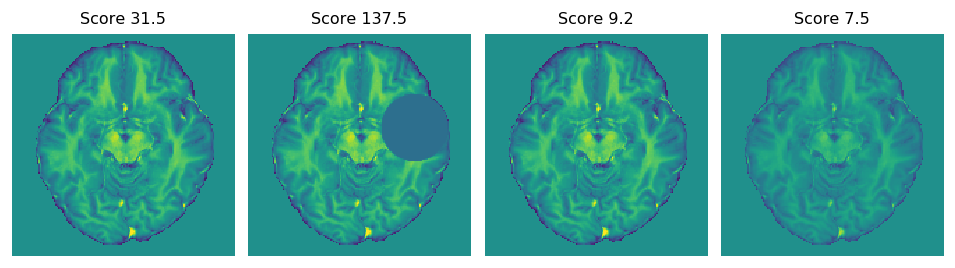

In [44]:
# Print a slice no [0,32] for each of the volumes with the scores for the slice
no = 10
fig,ax = plt.subplots(1,4,figsize = (8,8))

[a.imshow(mood_test[i].img[no],vmin=-3,vmax=3) for i,a in enumerate(ax)]
[a.set_title('Score {:.1f}'.format(pred[i,no])) for i,a in enumerate(ax)]
[a.axis('off') for a in ax]
plt.tight_layout()

In the docker submission, slice scores are normalized dividing by 200 and clipping to 1.

The score for the volume is just the sum of the slices. 

In [43]:
pred.sum(1)

array([ 791.76294, 1395.6531 , 1097.2164 , 1984.1964 ], dtype=float32)

## Pixel-wise scores

Pixel-wise score also utilizes densities estimated by the AR model. We restore anomalous slices by replacing high-loss latent codes with low-loss codes sampled by the AR model and decoding to pixel space using the VQ-VAE decoder. 

This process generates restorations of the original image, where encoded areas with low probability are replaced with normal areas as observed in the training set. For both datasets our method resamples latent variables with cross-entropy greater than 5, this correspond to the percentile 90 in holdout dataset.

Pixel-wise anomaly score is obtained comparing in pixel space the original image with the restorations, specifically:

$$Score_{pixel} = \sum_{j=1}^S \varphi_j\|y-r_j\|_{1}$$

Where $y$ is the test image pixel intensity, $r_j$ the pixel intensity for the restoration $j$ ∈ 1,2,...,S. We noted that the increase in samples contributes to reduce the variance of anomaly predictors, 15 samples are used in the submission.

Given the sequential sampling by the AR model we observed that some of the samples drift too much from the original image and contribute negatively to the anomaly localization. In order to address this issue, we introduced the weighting factor $\varphi$ defined as: 


$$\varphi_j = \text{softmax}(1/\sum_{i=1}^D\|y^i-r^i_j\|_{1})$$

Where the sum is over D pixels in the original pixel space. Note that this factor weights restorations based on the inverse of the distance between restorations and image, removing weight from restorations that are too different from the original image. Also note that modifying the softmax temperature allows the pixel score to transition from the mean of residuals among restorations to the residuals of the nearest restoration. In submission we use 3. as temperature because it seems to work best in the toy examples. Note that the introduction of the weight has a higher impact in the Abdominal dataset where restorations have a higher variance

In [47]:

def restore(model, n, img, cond = None, threshold_log_p = 5):
    """ Generate n restorations of images
        Returns restorations, both images and codes """
    
    model.eval()
        
    #Use VQ-VAE to encode original image
    codes = model.retrieve_codes(img,cond)
    code_size = codes.shape[-2:]
    
    with torch.no_grad():

        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)
        cond_repeat = cond.unsqueeze(1).repeat(1,n,1).reshape(img.shape[0]*n,-1)
        
        # Iterate through latent variables. 
        for r in range(code_size[0]):
            for c in range(code_size[1]):

                logits = model.forward_latent(samples, cond_repeat)[:, :, r, c]
                loss = F.cross_entropy(logits, samples[:, r, c], reduction='none')

                # Replace sample if above threshold
                probs = F.softmax(logits, dim=1)
                samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]
        
        # Retrieve z for the latent codes
        z = model.feature_extractor_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        
        # Decode to pixel space splitting computation in batches
        x_tilde = []
        for i in range(img.shape[0]):
            x_tilde.append(model.feature_extractor_model.decode(z[i*n:(i+1)*n],
                                               cond_repeat[i*n:(i+1)*n]))
        x_tilde = torch.cat(x_tilde)
              
    return x_tilde.reshape(img.shape[0],n,*img.shape[-2:]), samples.reshape(img.shape[0],n,*code_size)

mood_test_reconstructions = []
for X in mood_test:

    img = torch.from_numpy(X.img.copy()).to(device).float()
    coord = torch.from_numpy(X.coord.copy()).to(device).float()

    x_tilde, latent_sample = restore(model,n=15,img=img, cond=coord, threshold_log_p=5)
    mood_test_reconstructions.append(x_tilde)

In [50]:
img = torch.from_numpy(np.concatenate([x.img for x in mood_test]))
img_tilde = torch.cat(mood_test_reconstructions)
img_seg = torch.from_numpy(np.concatenate(mood_test_seg))

In [52]:
# (4 volumes x 32 slices, 15 restorations, 160,160)
print(img_tilde.shape)

# (4 volumes x 32 slices,160,160)
print(img_seg.shape)

torch.Size([128, 15, 160, 160])
torch.Size([128, 160, 160])


Visually compare original image with restoration:

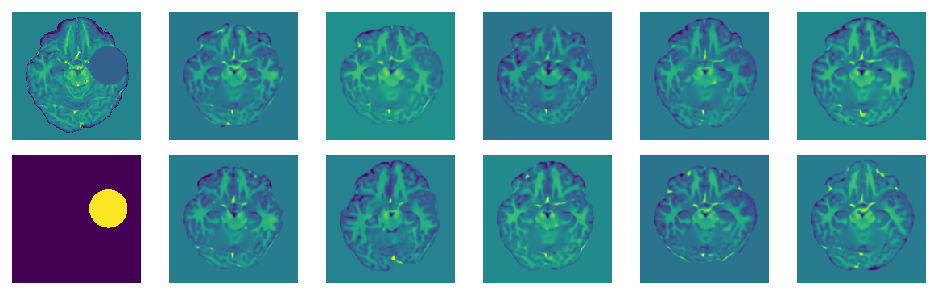

In [53]:
img_no = 1
slice_no = 9

fig, ax = plt.subplots(2,6, figsize=(8,2.5))
ax[0,0].imshow(mood_test[img_no].img[slice_no])
ax[0,0].axis('off')
ax[1,0].imshow(mood_test_seg[img_no][slice_no])
ax[1,0].axis('off')

for i in range(1,6):
    ax[0,i].imshow(mood_test_reconstructions[img_no][slice_no,i-1].cpu())
    ax[0,i].axis('off')

for i in range(1,6):
    ax[1,i].imshow(mood_test_reconstructions[img_no][slice_no,i-1+5].cpu())
    ax[1,i].axis('off')
plt.tight_layout()

L1(original image, restoration)

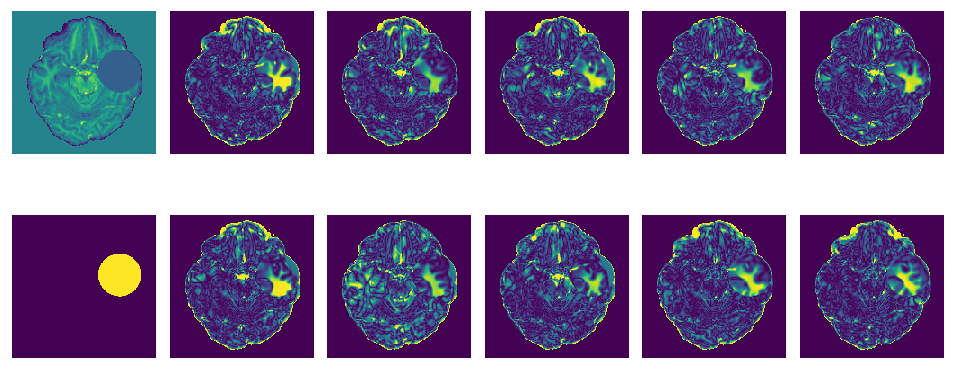

In [54]:
fig, ax = plt.subplots(2,6, figsize=(8,4))
ax[0,0].imshow(mood_test[img_no].img[slice_no])
ax[0,0].axis('off')
ax[1,0].imshow(mood_test_seg[img_no][slice_no])
ax[1,0].axis('off')
for i in range(1,6):
    tmp = np.abs(mood_test_reconstructions[img_no][slice_no,i-1].cpu() - mood_test[img_no].img[slice_no])
    ax[0,i].imshow(tmp,vmax=2)
    ax[0,i].axis('off')
for i in range(1,6):
    tmp = np.abs(mood_test_reconstructions[img_no][slice_no,i-1+5].cpu()- mood_test[img_no].img[slice_no])
    ax[1,i].imshow(tmp,vmax=2)    
    ax[1,i].axis('off')
plt.tight_layout()

In [55]:
# Post-processing of predictions
# Restorations are not as sharp as the original images which causes edges to have high variance. MinPooling is 
# used to smooth the edges (-MaxPooling(-x))

smooth = nn.Sequential(nn.MaxPool3d(kernel_size=3,padding=1,stride=1),
                       nn.AvgPool3d(kernel_size=(3,7,7),padding=(1,3,3),stride=1),
                      ).to(device)

In [56]:
# L1 distance restoration vs original image
diffs = torch.abs(img.unsqueeze(1).to(device).float()-img_tilde)

# Calculate restoration weight based on restoration similarity to original image
sim_imgwise = torch.mean(diffs,(2,3)).unsqueeze(2).unsqueeze(3)
sim_imgwise = torch.softmax(3/sim_imgwise,1)

# Pixel-wise score after weight 
diffs = (diffs*sim_imgwise).sum(1,keepdims=True)

# Post-process using Min Pool and average filter
diffs = diffs.squeeze().unsqueeze(0).unsqueeze(0)
smooth_diffs = -smooth(-diffs)
smooth_diffs = smooth_diffs.squeeze().unsqueeze(1)

# Average precission
metrics.average_precision_score(img_seg.flatten(),smooth_diffs.flatten().clamp_max(1.).cpu() / 1.)

0.8142442740139693

In [58]:
# ROCAUC
fpr, tpr, thresholds = metrics.roc_curve(img_seg.flatten(), smooth_diffs.flatten().cpu())
metrics.auc(fpr, tpr)

0.9924073794404051

In [67]:
# Dice Score
utils.max_score(img_seg.flatten(),smooth_diffs.flatten().cpu(), steps = 20)[0].item()

0.7621250152587891

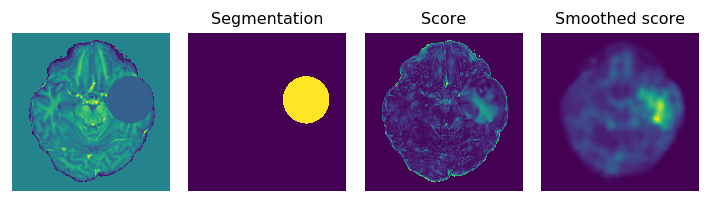

In [61]:
fig, ax = plt.subplots(1,4, figsize=(6,4))
ax[0].imshow(mood_test[img_no].img[slice_no])
ax[0].axis('off')
ax[1].imshow(mood_test_seg[img_no][slice_no])
ax[1].axis('off')
ax[1].set_title('Segmentation')
ax[2].imshow(diffs.squeeze()[img_no * 32 + slice_no].cpu())
ax[2].axis('off')
ax[2].set_title('Score')
ax[3].imshow(smooth_diffs[img_no * 32 + slice_no].squeeze().cpu())
ax[3].axis('off')
ax[3].set_title('Smoothed score')

plt.tight_layout()

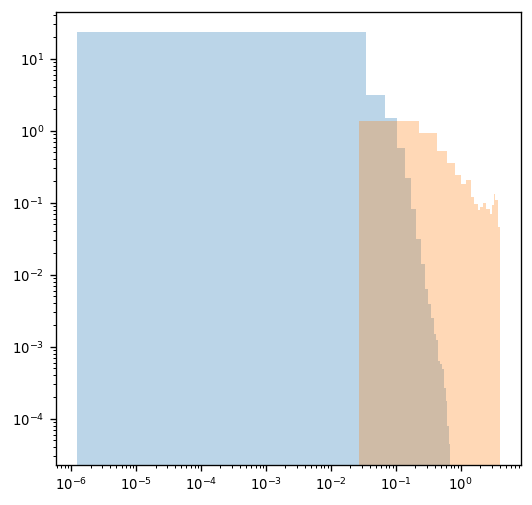

In [63]:
# Anomaly score histogram, anomalous vs normal
plt.hist(smooth_diffs.flatten().cpu()[img_seg.flatten()==0],alpha=.3,bins=20,density=True)
plt.hist(smooth_diffs.flatten().cpu()[img_seg.flatten()==1],alpha=.3,bins=20,density=True)
plt.xscale('log')
plt.yscale('log')